### Initial Setup and Imports

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class hpstrHistFile :
    """A file of histograms generated by hpstr
    
    hpstr produces a file of histograms with a formulaic structure.
    
    Parmaeters
    ----------
    fp : str
        File path to hist file
    analysis : str
        Name of analysis in hist file (name given to HistoManager)
    copies : list[str]
        list of copie names (as given to HistoManager)
    """
    
    def __init__(self, fp, analysis, copies = []) :
        self.__analysis_dir = uproot.open(f'{fp}:{analysis}')
        self.__analysis = analysis
        self.__copies = copies
    
    def __construct_key(self,hist_name,*,selection = None, include_prefix=True) :
        """Get a histogram from this analysis
        
        Parameters
        ----------
        hist_name : str
            Name of histogram including dimensionality extension
        selection : str, int
            Name (or index) of selection ("copies" created by HistoManager)
        include_prefix : bool
            Include the analysis name prefix defined by HistoManager
        """
        key = []
        if include_prefix :
            key.append(self.__analysis)
        if selection is not None :
            if isinstance(selection,int) :
                key.append(self.__copies[selection])
            else :
                key.append(selection)
            key.append('follow')
        key.append(hist_name)
        return '_'.join(key)
            
    def get(self,*args,**kwargs) :
        """Get a histogram from this analysis
        
        All args and kwargs are forwarded to __construct_key
        """
        k = self.__construct_key(*args,**kwargs)
        return self.__analysis_dir[k]
    
    def __deduce_selections(self,selections) :
        if len(self.__copies) == 0 :
            return [None]
        elif selections is True :
            return self.__copies
        else :
            return self.__copies[selections]
    
    def plot_1d(self,hist_name, xlabel, *, 
                ax = None, selections = None, title = None) :
        if ax is None :
            fig, ax = plt.subplots()
        if isinstance(hist_name,dict) :
            # plotting multiple histograms 
            #  instead of following one through selections
            for name, hist in hist_name.items() :
                if not hist.endswith('_h') :
                    hist += '_h'
                self.get(hist).to_hist().plot(ax=ax,label=name)
        else :
            if not hist_name.endswith('_h') :
                hist_name += '_h'
            if selections is not None :
                # follow single histogram through the event selections
                for name in self.__deduce_selections(selections) :
                    self.get(hist_name, selection = name).to_hist().plot(ax=ax,label=name)
            else :
                # just plot the single histogram
                self.get(hist_name).to_hist().plot(ax=ax,label=hist_name)
        plt.legend()
        plt.ylabel('Event Count')
        plt.yscale('log')
        plt.xlabel(xlabel)
        if title is not None :
            plt.title(title)
        plt.show()
        
    def plot_2d(self,hist_name, xlabel, ylabel, *, 
                selections = None, size = None, title = None) :
        if isinstance(hist_name,dict) :
            fig, axl = plt.subplots(nrows=len(hist_name))
            for ax, (name, hist) in zip(axl,hist_name.items()) :
                if not hist.endswith('_hh') :
                    hist += '_hh'
                self.get(hist).to_hist().plot(ax=ax, cmin=1)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_title(name)
            fig.tight_layout()
        elif selections is not None :
            sels = self.__deduce_selections(selections)
            fig, axl = plt.subplots(nrows=len(sels))
            if size is not None :
                fig.set_size_inches(*size)
            if not hist_name.endswith('_hh') :
                hist_name += '_hh'
            for name, ax in zip(sels,axl) :
                self.get(hist_name,selection=name).to_hist().plot(ax=ax, cmin=1)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_title(name)
            fig.tight_layout()
        else :
            fig, ax = plt.subplots()
            if size is not None :
                fig.set_size_inches(*size)
            self.get(hist_name).to_hist().plot(ax=ax, cmin=1)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        if title is not None :
            plt.suptitle(title, y = 1.01)
        plt.show()
        

## Plotting HPS Analysis Histograms
Histograms produced by using `hpstr` to analyze ntuples decoded from lcio files.

### Dependencies
- uproot
- matplotlib
- numpy
- hist[plot]

In [16]:
f = hpstrHistFile('2016-subsample/hist_2016_subsample_run_007800_part_0000_0020.root','tpt',
                  ['pre_fiducial_cut','pre_time_cut','pre_esum_cut','final_selection'])

## Selection Cuts
We are trying to develop a series of cuts that allows us to select Three Prong Trident (TPT) events.
These events have historically been helpful for studying the tracking efficiency, so we also want
to keep that in mind when selecting cuts and avoid using the tracks themselves until the last moment.

In `ThreeProngTridentTracksAnalyzer`, I have implemented two different selections "cluster" and "event" selections.

### Cluster Cuts

FEE = Full Energy Electrons

Cut | Description | Reason
----|-------------|--------
E < 2GeV | Energy less than 87% of the beam energy | Don't want events where a FEE happens to also have two mini clusters
E > 0.1GeV | Energy greater than 100MeV | Want clusters that are substantial
e- | clusters with x < 0mm | Sort clusters into electron candidates by bend in magnetic field
e+ | clusters with x > 100mm | sort clusters into positron candidates by bend in magnetic field

After performing the cluster cuts, we can move onto the event cuts which rely on already chosen positron and electron candidate clusters.

### Event Cuts
The three "trident clusters" are chose after making sure there are enough positron/electrons.
The highest energy positron cluster and the two highest energy electron clusters are the three trident clusters.

Cut | Description | Reason
----|-------------|--------
\>= 1 positron | at least one positron candidate cluster | tridents produce a positron
\>= 2 electrons | at least two electron candidate clusters | tridents produce two electrons
\<= 1 positron | maximum of one positron candidate |
\<= 2 electrons | maximum of two electron candidates |
fiducial | none of the trident clusters have seeds on the edge | make sure clusters have a good estimate of the energy
within 2ns | maximum time difference between any two of the trident clusters is 2ns | tridents happen in-time so the clusters should be close to the same time

These last two cuts have the biggest effect on the sample, so we have histograms filled in between them.

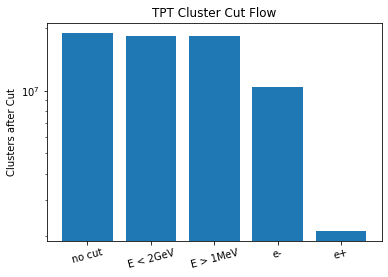

In [17]:
plt.bar(['no cut', 'E < 2GeV', 'E > 1MeV', 'e-', 'e+'],
        f.get('cluster_selection_cutflow',include_prefix=False).values())
plt.xticks(rotation = 15)
plt.yscale('log')
plt.ylabel('Clusters after Cut')
plt.title('TPT Cluster Cut Flow')
plt.show()

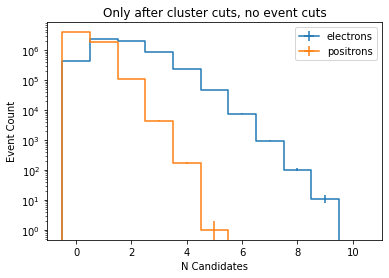

In [18]:
f.plot_1d({'electrons' : 'n_electron_candidates',
           'positrons' : 'n_positron_candidates'},
          'N Candidates', title = 'Only after cluster cuts, no event cuts')

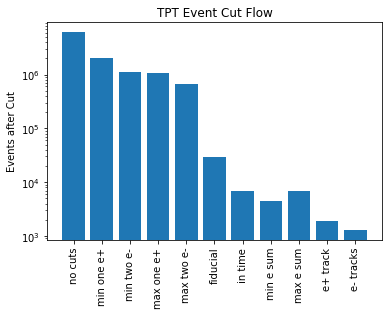

In [19]:
h = f.get('event_selection_cutflow',include_prefix=False)
plt.bar(['no cuts','min one e+','min two e-','max one e+','max two e-','fiducial','in time','min e sum','max e sum','e+ track','e- tracks']
    ,h.values())
plt.xticks(rotation = 90)
plt.yscale('log')
plt.title('TPT Event Cut Flow')
plt.ylabel('Events after Cut')
plt.show()

## Cluster Variables
During the last two cuts, we want to study how the cluster variables evolve. Below, we have various cluster variables and meta-variables plotted.

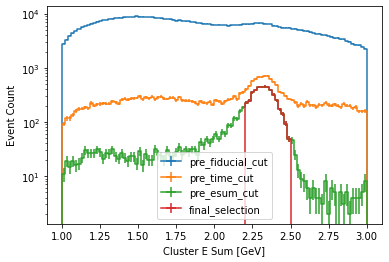

In [20]:
f.plot_1d('cluster_E_sum','Cluster E Sum [GeV]',selections=True)

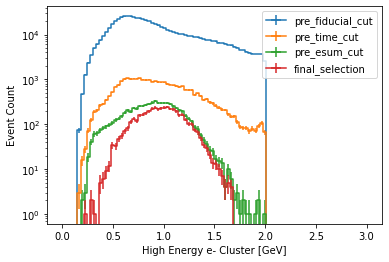

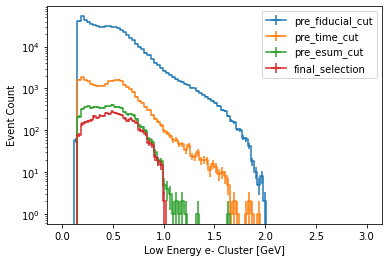

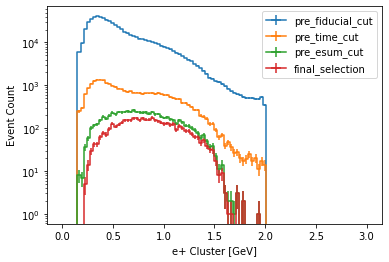

In [21]:
f.plot_1d('electron0_cluster_E', 'High Energy e- Cluster [GeV]',selections=True)
f.plot_1d('electron1_cluster_E', 'Low Energy e- Cluster [GeV]',selections=True)
f.plot_1d('positron_cluster_E', 'e+ Cluster [GeV]',selections=True)

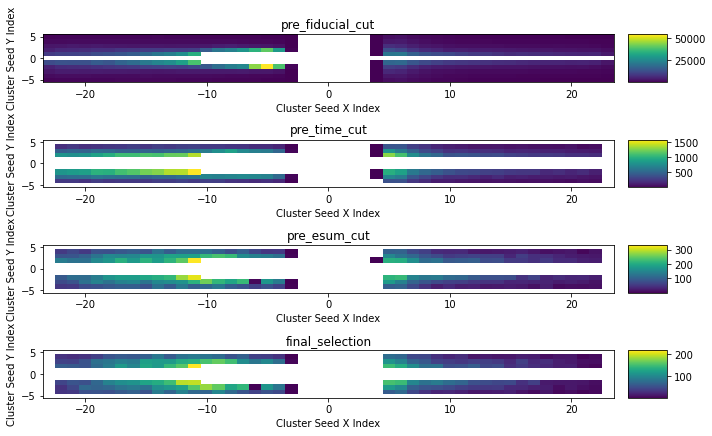

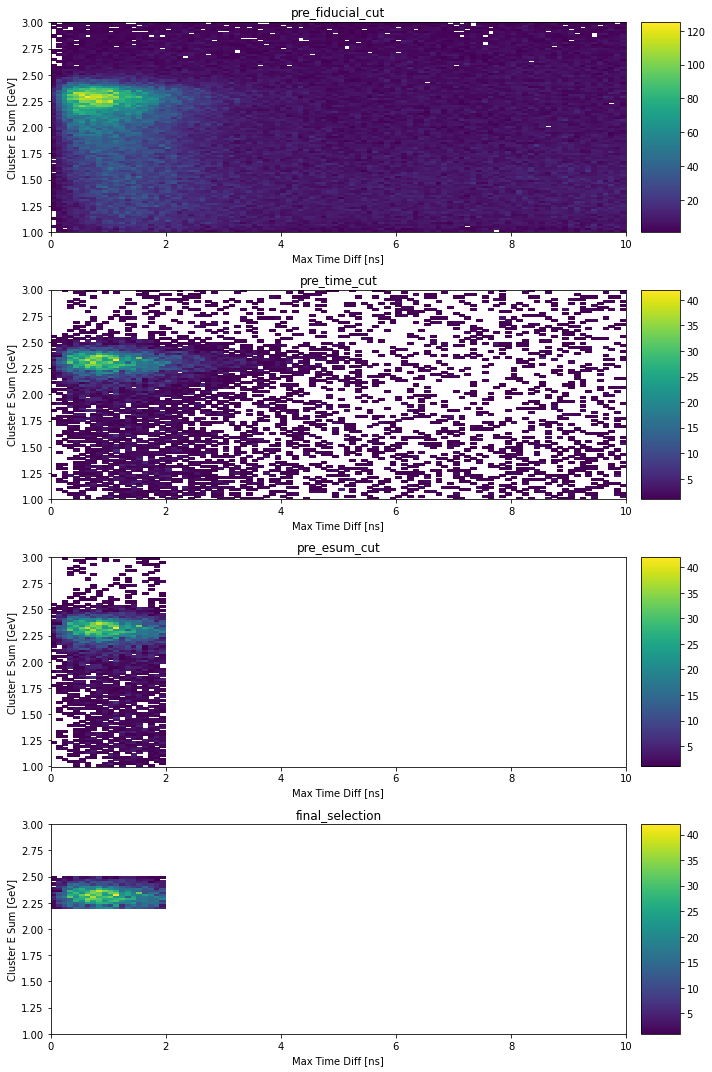

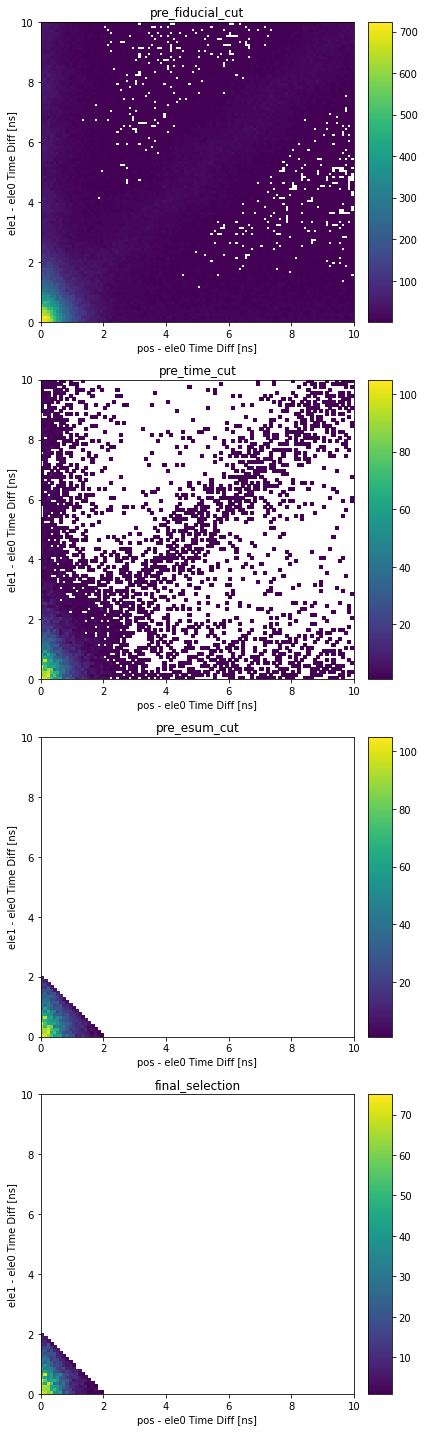

In [22]:
f.plot_2d('cluster_seed_pos','Cluster Seed X Index', 'Cluster Seed Y Index',selections=True,size=(10,6))
f.plot_2d('max_time_diff_vs_E_sum','Max Time Diff [ns]', 'Cluster E Sum [GeV]',selections=True,size=(10,15))
f.plot_2d('time_diff','pos - ele0 Time Diff [ns]', 'ele1 - ele0 Time Diff [ns]',selections=True,size=(6,20))

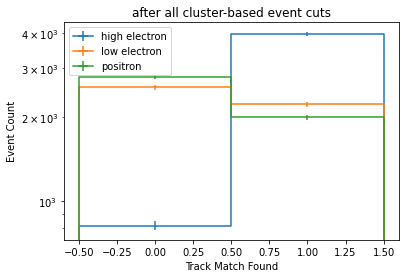

In [11]:
f.plot_1d({'high electron' : 'electron0_track_N',
           'low electron' : 'electron1_track_N',
           'positron' : 'positron_track_N' },
          'Track Match Found', title = 'after all cluster-based event cuts')

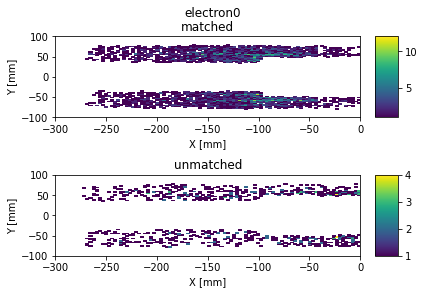

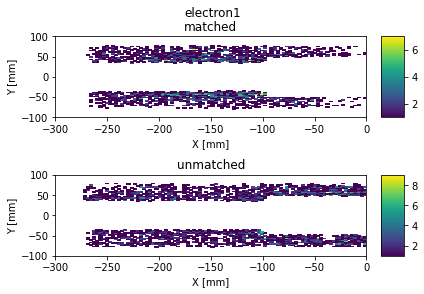

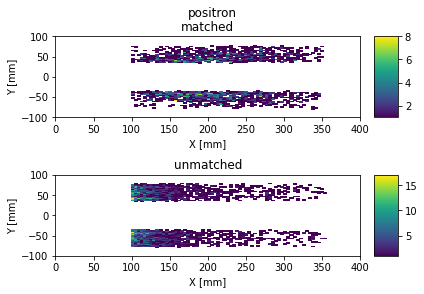

In [12]:
for p in ['electron0','electron1','positron'] :
    f.plot_2d({m : f'{p}_{m}_x_y' for m in ['matched','unmatched']}, 'X [mm]', 'Y [mm]', title = p)